### Deformation Field Overlaying into the Moving Image

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from   natsort import natsorted
from scipy.ndimage import gaussian_filter, map_coordinates

In [2]:
# Function to get the deformation field and moving images
def get_file_paths(directory):
    file_types = {
        'flow.nii.gz': []
    }
    
    for filename in os.listdir(directory):
        for file_suffix in file_types:
            if filename.endswith(file_suffix):
                file_types[file_suffix].append(os.path.join(directory, filename))
                break
    for key in file_types:
        file_types[key] = natsorted(file_types[key])
    
    return file_types

In [3]:
def load_nifti_image(file_path):
    nii   = nib.load(file_path)
    image = nii.get_fdata()
    return image, nii.affine

In [4]:
def load_deformation_field(file_path):
    nii = nib.load(file_path)
    deformation_field = nii.get_fdata()
    return deformation_field

In [5]:
def get_deformation_field_magnitude(directories):
    defMag_all = []
    for directory in directories:
        defMag = get_file_paths(directory)
        defMag_all.append(defMag['flow.nii.gz'])
    return defMag_all
        

In [6]:
def get_min_max_from_nifti(file_path):
    img = nib.load(file_path)  # Load the .nii.gz file
    data = img.get_fdata()  # Get the data as a NumPy array
    return data.min(), data.max()

In [11]:
def save_min_max_from_defMag(deformation_field_paths):
    results = []

    # Initialize variables to track the global minimum and maximum
    global_min = float('inf')   # Start with a very high value
    global_max = float('-inf')  # Start with a very low value

    # Loop through each list of paths and calculate the min and max for each file
    for file_list in deformation_field_paths:
        for file_path in file_list:
            if os.path.exists(file_path):
                min_val, max_val = get_min_max_from_nifti(file_path)
                
                # Append individual file results
                results.append({
                    'File': file_path,
                    'Min Value': min_val,
                    'Max Value': max_val
                })
                
                # Update the global minimum and maximum
                global_min = min(global_min, min_val)
                global_max = max(global_max, max_val)
            else:
                print(f"File not found: {file_path}")

    # Convert the results to a pandas DataFrame
    df = pd.DataFrame(results)

    # Save the individual file results to an Excel file
    output_excel_file = 'deformation_field_min_max.xlsx'
    df.to_excel(output_excel_file, index=False)

    # Print the global minimum and maximum
    print(f"Global Min Value: {global_min}")
    print(f"Global Max Value: {global_max}")

    # Optionally, you could add the global min/max to the Excel file as a summary
    with pd.ExcelWriter(output_excel_file, mode='a', engine='openpyxl') as writer:
        summary_df = pd.DataFrame({
            'Global Min': [global_min],
            'Global Max': [global_max]
        })
        summary_df.to_excel(writer, index=False, sheet_name='Summary')

    print(f"Results saved to {output_excel_file} with global min/max.")
    
    return global_min, global_max

In [26]:
def plot_deformation_with_colorbar(def_mag, max_magnitude, cmap='viridis', output_file='./def_mag.png'):
    # Plot slices from the 3D data
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Select slices (middle slice in each dimension)
    slice_x =  np.transpose(def_mag[def_mag.shape[0] // 3, :, :], (1, 0))
    slice_y =  np.transpose(def_mag[:, def_mag.shape[1] // 3, :], (1, 0))
    slice_z =  np.transpose(def_mag[:, :, def_mag.shape[2] // 3], (1, 0))

    slices = [slice_x, slice_y, slice_z]
    titles = ['Sagittal Slice', 'Coronal Slice', 'Axial Slice']

    for i, ax in enumerate(axes):
        im = ax.imshow(slices[i], cmap=cmap, origin='lower',
                       vmin=0, vmax=max_magnitude)
        ax.set_title(titles[i])
        fig.colorbar(im, ax=ax)

    plt.show()
    #plt.savefig(output_file)
    plt.close()

In [27]:
def visualize_deformation_field(deformation_field_paths, max_magitude):
    for file_list in deformation_field_paths:
        for file_path in file_list:
            magnitude = load_deformation_field(file_path)
            plot_deformation_with_colorbar(magnitude, max_magnitude)

In [14]:
# Get the min and max values from the deformation field of all patients
vxm_directory     = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Jul31-053533_Abtrain_VXMx1___/'
vtn_directory     = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Aug06-211340_Abtrain_VTNx3___/'
tsm_directory     = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Aug07-042242_Abtrain_TSMx1___/'
methods_directory = [vxm_directory, vtn_directory, tsm_directory]
def_mag_paths     = get_deformation_field_magnitude(methods_directory)
min_mag, max_mag  = save_min_max_from_defMag(def_mag_paths)

Global Min Value: 0.0009969105012714863
Global Max Value: 59.81889343261719
Results saved to deformation_field_min_max.xlsx with global min/max.


##### VoxelMorph

In [28]:
# VoxelMorph Directory
vxm_directory   = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Jul31-053533_Abtrain_VXMx1___/'
vxm_defMag_dir  = vxm_directory + 'defMag_figures/'
image_paths     = get_file_paths(vxm_directory)
flow_paths      = image_paths['flow.nii.gz']

flow_0_paths    = flow_paths[0]
flow_54_paths   = flow_paths[54]

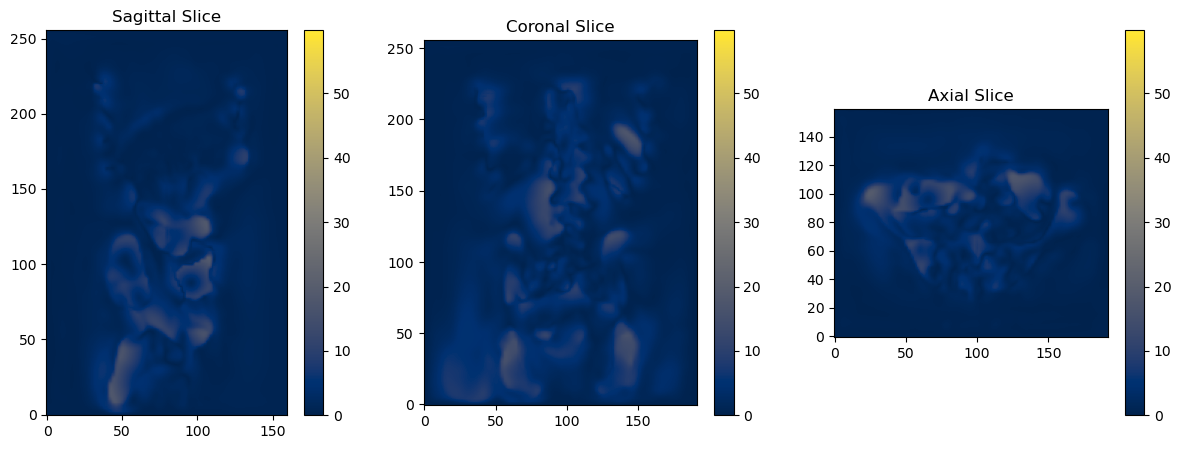

In [31]:
deformation_magnitude = load_deformation_field(flow_0_paths)
plot_deformation_with_colorbar(deformation_magnitude, max_mag, cmap='cividis')


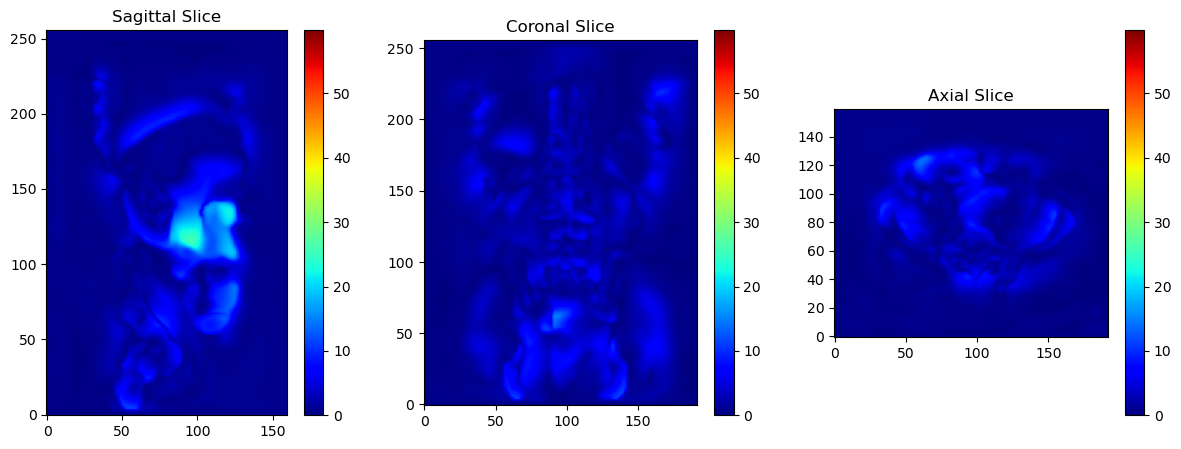

In [32]:
deformation_magnitude = load_deformation_field(flow_54_paths)
plot_deformation_with_colorbar(deformation_magnitude, max_mag, cmap='jet')

##### VTN

In [33]:
# VTN Directory
vtn_directory    = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Aug06-211340_Abtrain_VTNx3___/'
vtn_defMag_dir  = vtn_directory + 'defMag_figures/'
image_paths     = get_file_paths(vtn_directory)
flow_paths      = image_paths['flow.nii.gz']

flow_0_paths    = flow_paths[0]
flow_54_paths   = flow_paths[54]

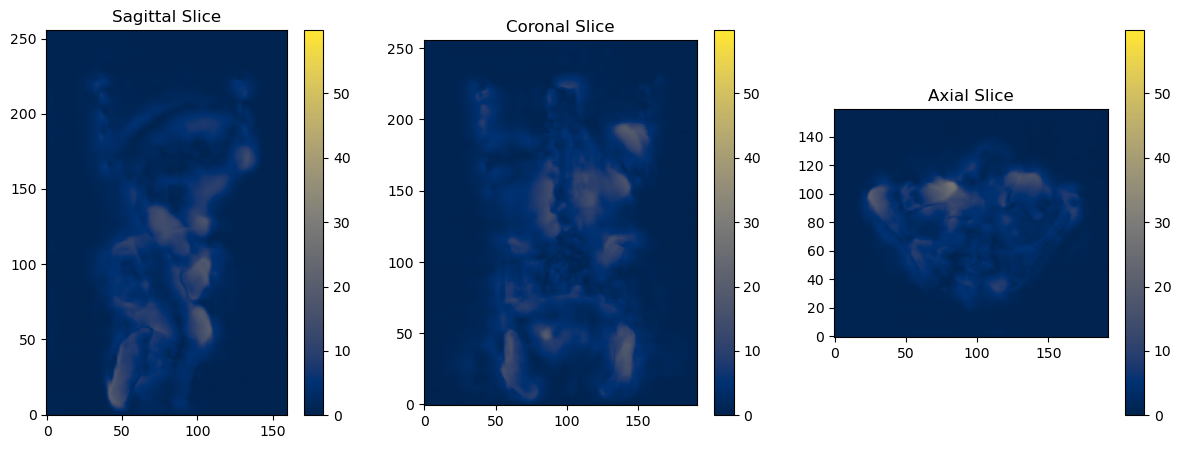

In [34]:
deformation_magnitude = load_deformation_field(flow_0_paths)
plot_deformation_with_colorbar(deformation_magnitude, max_mag, cmap='cividis')

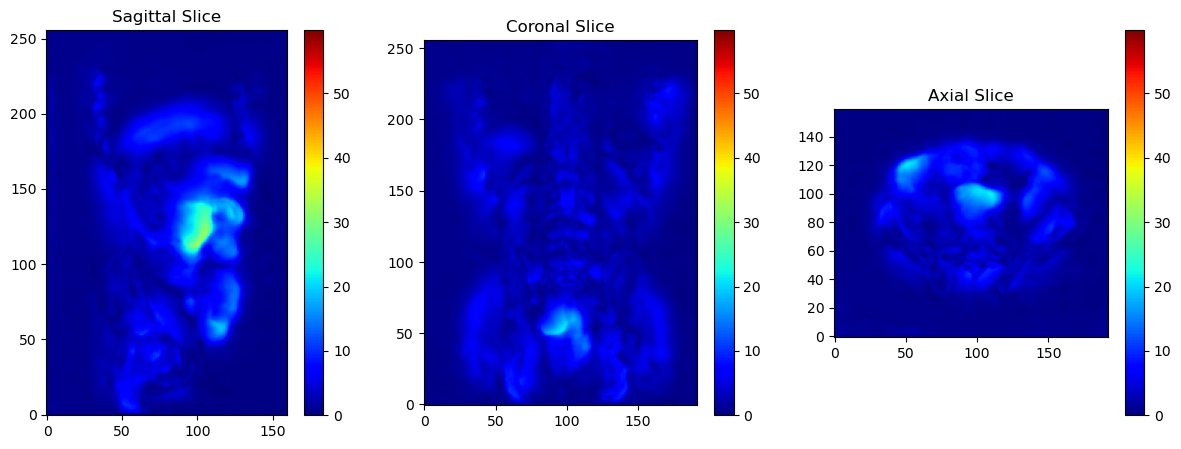

In [35]:
deformation_magnitude = load_deformation_field(flow_54_paths)
plot_deformation_with_colorbar(deformation_magnitude, max_mag, cmap='jet')

##### TSM

In [36]:
# VoxelMorph Directory
tsm_directory  = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Aug07-042242_Abtrain_TSMx1___/'
tsm_defMag_dir = tsm_directory + 'defMag_figures/'
image_paths    = get_file_paths(tsm_directory)
flow_paths     = image_paths['flow.nii.gz']

flow_0_paths   = flow_paths[0]
flow_54_paths  = flow_paths[54]

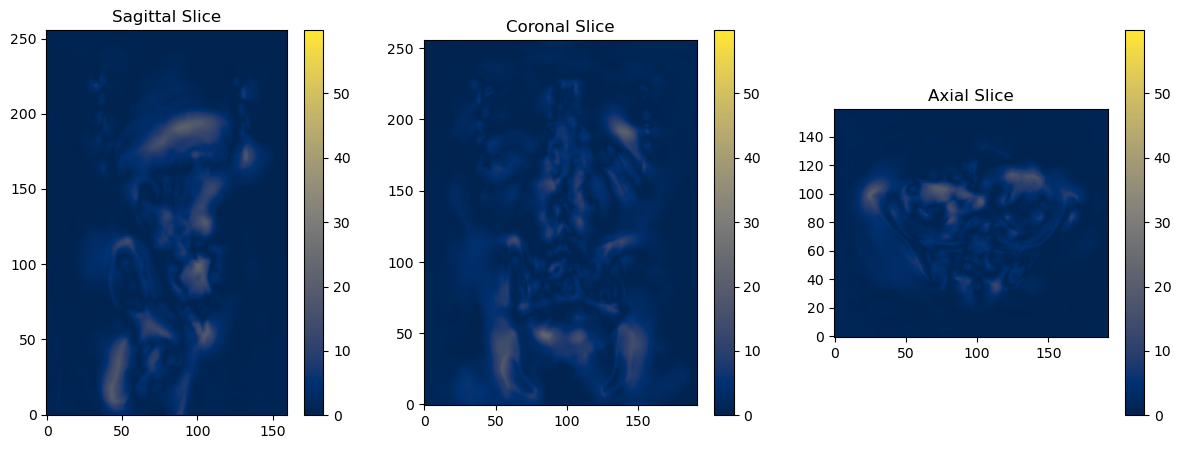

In [37]:
deformation_magnitude = load_deformation_field(flow_0_paths)
plot_deformation_with_colorbar(deformation_magnitude, max_mag, cmap='cividis')

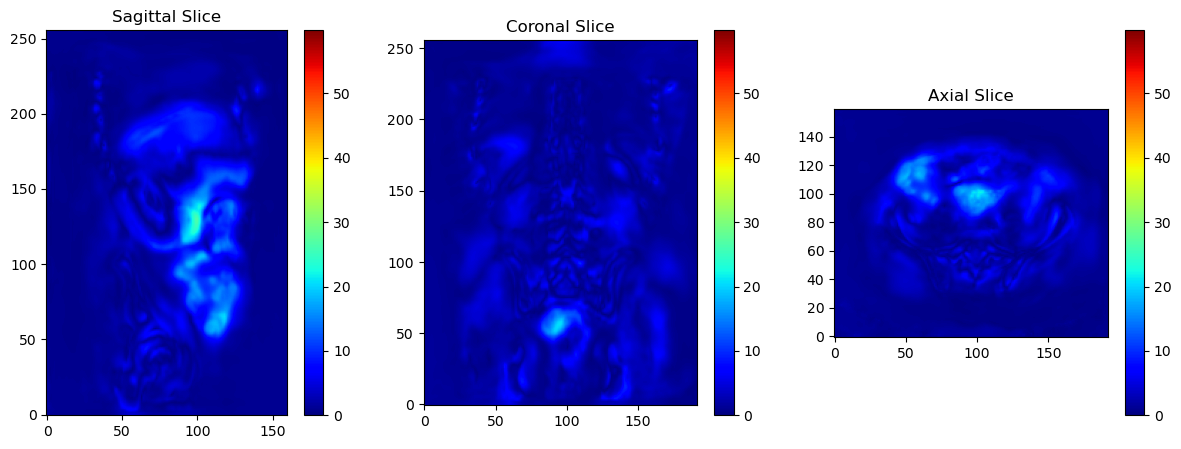

In [38]:
deformation_magnitude = load_deformation_field(flow_54_paths)
plot_deformation_with_colorbar(deformation_magnitude, max_mag, cmap='jet')